In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [21]:
data = pd.read_csv('air_quality.csv', sep=';', decimal=',', header=0)
data = data.drop(columns = ['Unnamed: 15', 'Unnamed: 16']).dropna().replace(-200, np.nan)
print(data.isna().sum())
data = data.drop(columns = ['Date', 'Time', 'NMHC(GT)']) # 'NMHC(GT)' has 8443 missing values which is too much considering total of 9k instances

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


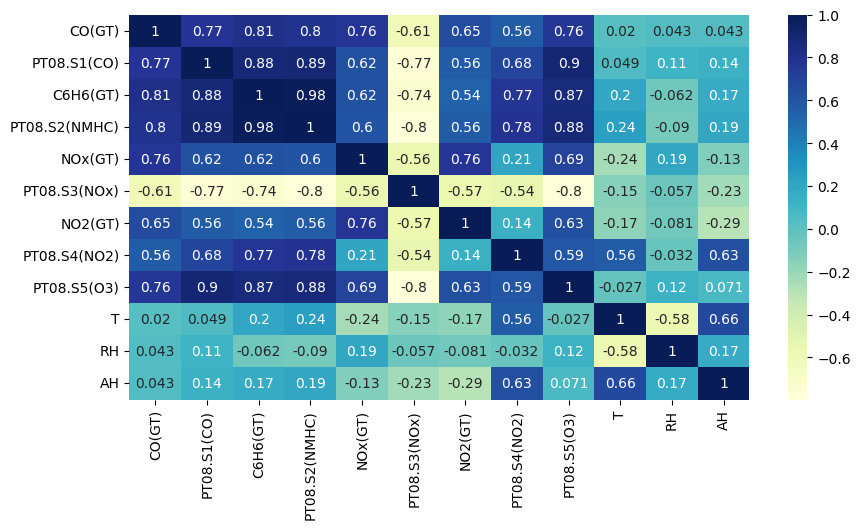

In [22]:
for i, col in enumerate(data.columns):
  data[col] = data[col].fillna(data[col].mean())
data.isna().sum()

plt.figure(figsize=(10,5))
sns.heatmap(data.corr(),cmap='YlGnBu',annot=True)
plt.show()

In [23]:
X = data.drop(columns = ['CO(GT)'])
y = data['CO(GT)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

In [25]:
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Ridge": (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
    "Lasso": (Lasso(), {'alpha': [0.01, 0.1, 1.0]}),
    "Random Forest": (RandomForestRegressor(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}),
    "Gradient Boosting": (GradientBoostingRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01]}),
    "Multi-Layer Perceptron": (MLPRegressor(), {'hidden_layer_sizes': [(40, 40, 40)], 'activation': ['relu'], 'alpha': [0.01], 'learning_rate': ['constant'], 'solver': ['adam']}),
    "K-Nearest Neighbors": (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']})
}

In [26]:
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    mse, r2 = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)
    
    results[model_name] = {'mse': mse, 'r2': r2, 'best_params': best_params, 'best_model': best_model }

    print(f"{model_name}:")
    print(f"  Best Parameters: {best_params}")
    print(f"  MSE: {mse}")
    print(f"  R2: {r2}")
    print()


Linear Regression:
  Best Parameters: {}
  MSE: 0.3462349740124412
  R2: 0.8135076041920022

Ridge:
  Best Parameters: {'alpha': 10.0}
  MSE: 0.3468072220356054
  R2: 0.8131993744842996

Lasso:
  Best Parameters: {'alpha': 0.01}
  MSE: 0.355998880358068
  R2: 0.8082484754975814

Random Forest:
  Best Parameters: {'max_depth': None, 'n_estimators': 300}
  MSE: 0.23380506276640045
  R2: 0.8740656791483504

Gradient Boosting:
  Best Parameters: {'learning_rate': 0.1, 'n_estimators': 300}
  MSE: 0.2693410314679276
  R2: 0.8549249555417638

Multi-Layer Perceptron:
  Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (40, 40, 40), 'learning_rate': 'constant', 'solver': 'adam'}
  MSE: 0.2348542053261994
  R2: 0.8735005799405678

K-Nearest Neighbors:
  Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}
  MSE: 0.24345962160433451
  R2: 0.8688654482551799



In [27]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by='mse', ascending=True, inplace=True)
print(results_df)

                             mse        r2  \
Random Forest           0.233805  0.874066   
Multi-Layer Perceptron  0.234854  0.873501   
K-Nearest Neighbors      0.24346  0.868865   
Gradient Boosting       0.269341  0.854925   
Linear Regression       0.346235  0.813508   
Ridge                   0.346807  0.813199   
Lasso                   0.355999  0.808248   

                                                              best_params  \
Random Forest                    {'max_depth': None, 'n_estimators': 300}   
Multi-Layer Perceptron  {'activation': 'relu', 'alpha': 0.01, 'hidden_...   
K-Nearest Neighbors             {'n_neighbors': 7, 'weights': 'distance'}   
Gradient Boosting             {'learning_rate': 0.1, 'n_estimators': 300}   
Linear Regression                                                      {}   
Ridge                                                     {'alpha': 10.0}   
Lasso                                                     {'alpha': 0.01}   

              

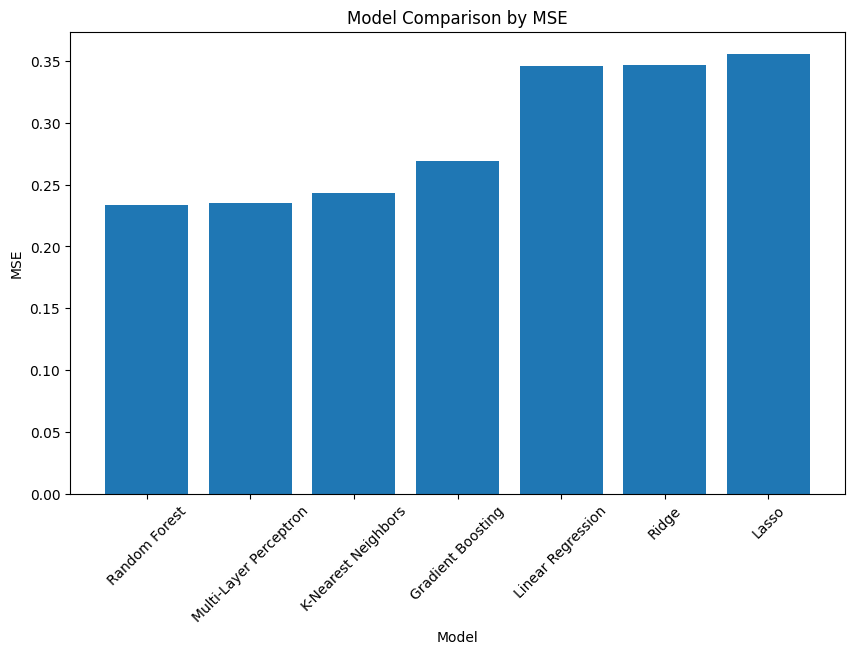

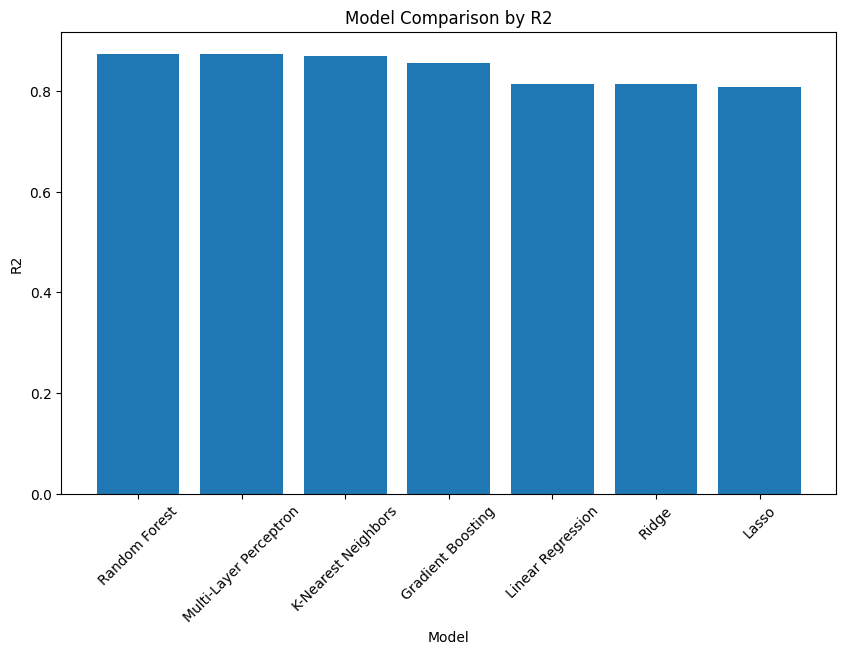

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['mse'])
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Comparison by MSE')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['r2'])
plt.xlabel('Model')
plt.ylabel('R2')
plt.title('Model Comparison by R2')
plt.xticks(rotation=45)
plt.show()

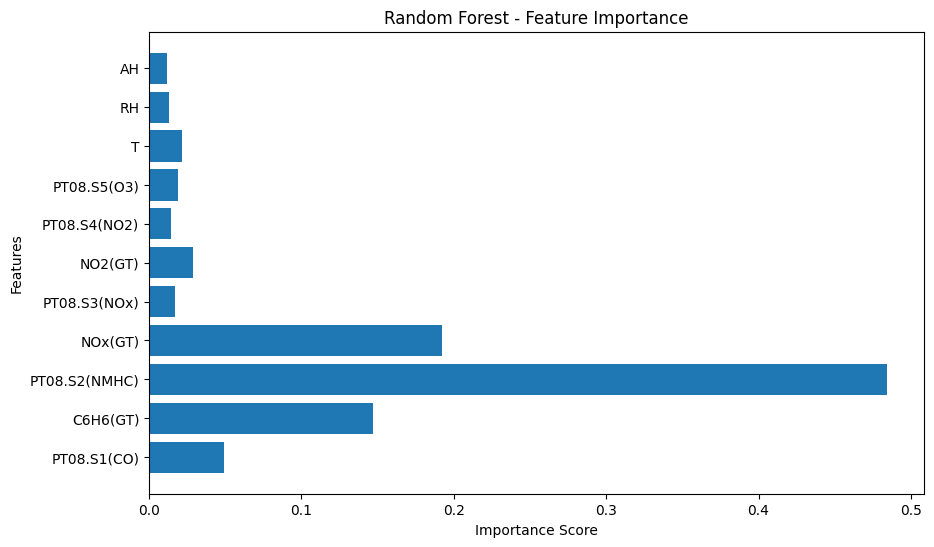

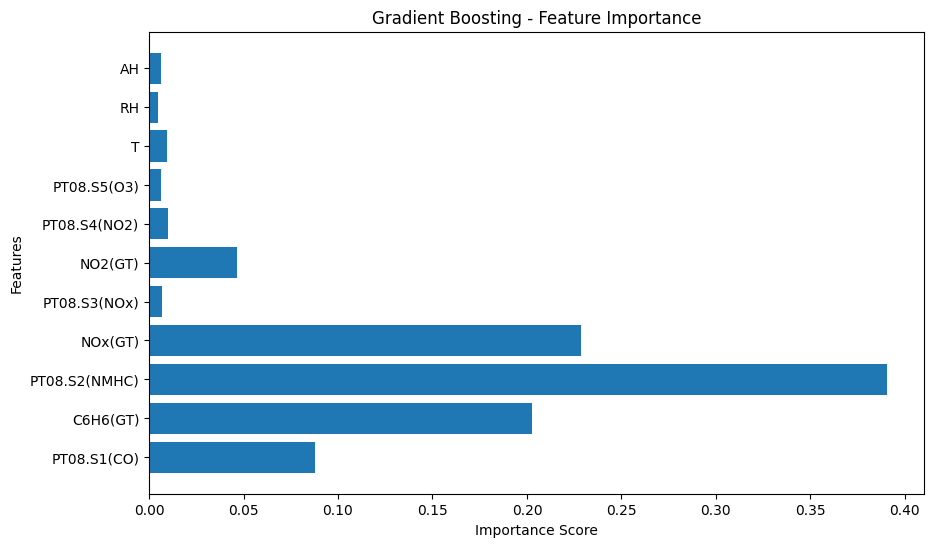

In [31]:
def plot_feature_importance(model, model_name):
    importance = model.feature_importances_
    features = X.columns
    plt.figure(figsize=(10, 6))
    plt.barh(features, importance)
    plt.title(f'{model_name} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
# RandomForest feature importance
plot_feature_importance(results['Random Forest']['best_model'], 'Random Forest')

# GradientBoosting feature importance
plot_feature_importance(results['Gradient Boosting']['best_model'], 'Gradient Boosting')


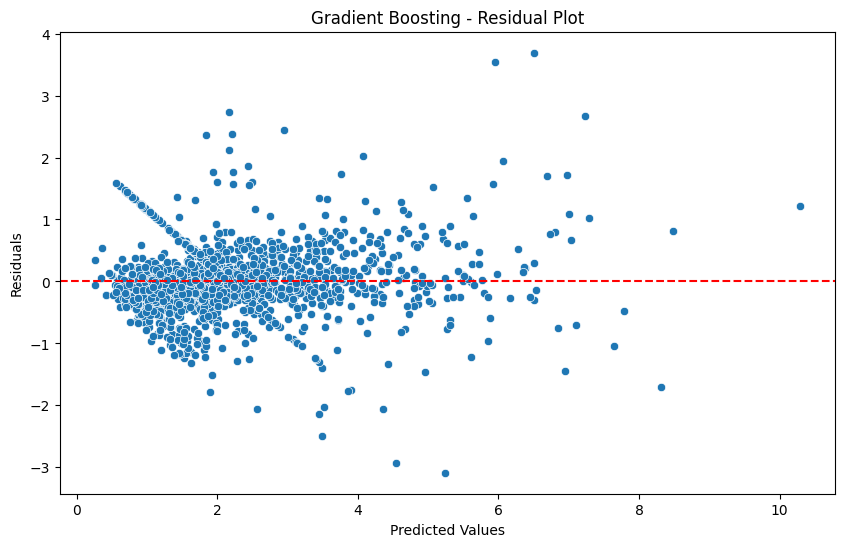

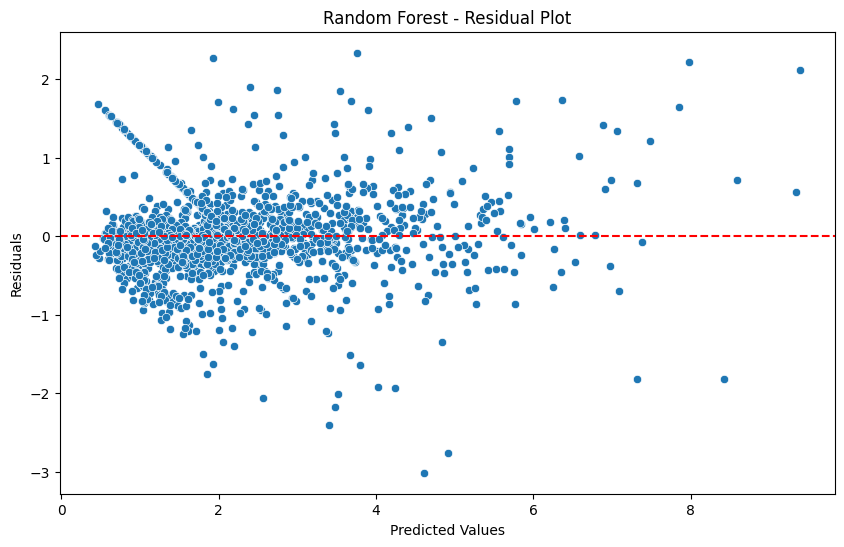

In [33]:
def plot_residuals(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    residuals = y_test - y_pred

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')
    plt.show()

# Example for Gradient Boosting
plot_residuals(results['Gradient Boosting']['best_model'], X_test_scaled, y_test, 'Gradient Boosting')
plot_residuals(results['Random Forest']['best_model'], X_test_scaled, y_test, 'Random Forest')

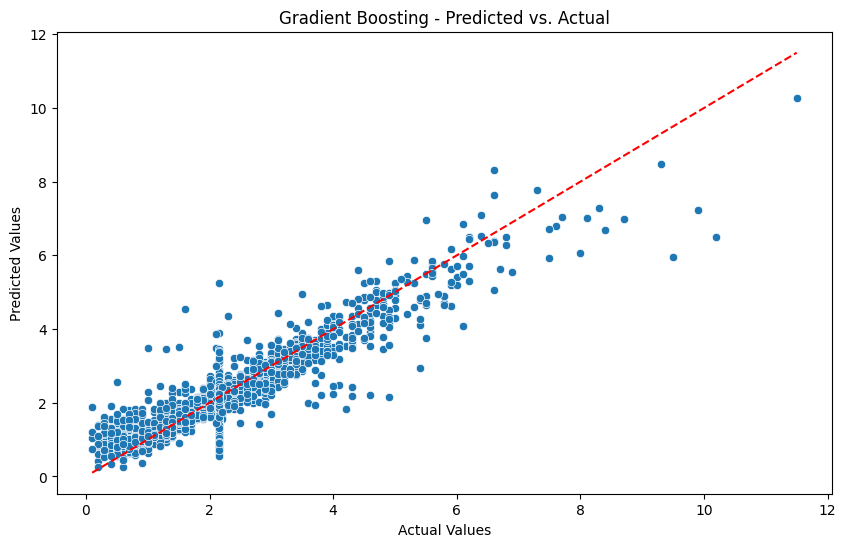

In [34]:
def plot_predicted_vs_actual(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Predicted vs. Actual')
    plt.show()

# Example for Gradient Boosting
plot_predicted_vs_actual(results['Gradient Boosting']['best_model'], X_test_scaled, y_test, 'Gradient Boosting')
